In [9]:
from scipy.stats import iqr,skew,kurtosis,variation
from datetime import datetime
from copy import deepcopy
import math
from scipy.stats import pearsonr
from sklearn.externals.joblib import Parallel,delayed
import warnings
import pandas as pd
import pickle
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.metrics import f1_score,r2_score,classification_report,roc_auc_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,RandomForestRegressor
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV,StratifiedKFold
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

def get_daywise(data,ema):
    df_col = []
    for day in np.unique(ema['day'].values):
        df = data[data.day.isin([day])]
        if df.shape[0]<60:
            continue
        df_day = ema[ema.day.isin([day])]
        if df_day.shape[0]<1:
            continue
#         print(df.shape,df_day.shape)
        df_col.append([df,df_day])
    return df_col

def get_xy(a,ema):
    a = a[['time','ltime','quality_mag_1','stress_likelihood1']].dropna().sort_values('time').reset_index(drop=True)
    X_f = np.array(list(a['quality_mag_1'].values))
#     print(X_f.shape)
    t = np.array(list(a['time'].values))
    X_s = np.array(list(a['stress_likelihood1'].values))
    X_s = X_s[t.argsort()]
    X_f = X_f[t.argsort()]
    t = t[t.argsort()]
    ema = ema.sort_values('time').reset_index(drop=True)
    X = []
    y = []
    for i,row in ema.iterrows():
        time = row['time']
        diff = np.abs(t - time).min()
        if diff>600:
            continue
        index = np.abs(t - time).argmin()
        if index<5:
            continue
        if index<10:
            X.append([X_s[0:index],X_f[0:index]])
        else:
            X.append([X_s[index-10:index],X_f[index-10:index]])
        y.append(row['label'])
    return X,y

def get_features1(x1):
    x = x1[0]
    temp = []
    temp.append(x[-1])
    temp.append(x[0])
    temp.append(x[len(x)//2])
    temp.append(iqr(x))
    temp.append(skew(x))
    temp.append(kurtosis(x))
    temp.append(variation(x))
#     temp.append(iqr(x[:len(x)//2]))
#     temp.append(skew(x[:len(x)//2]))
#     temp.append(kurtosis(x[:len(x)//2]))
#     temp.append(variation(x[:len(x)//2]))
#     temp.append(iqr(x[len(x)//2:]))
#     temp.append(skew(x[len(x)//2:]))
#     temp.append(kurtosis(x[len(x)//2:]))
#     temp.append(variation(x[len(x)//2:]))
    return np.array(temp)

def f1Bias_scorer_CV(probs, y, ret_bias=False):
    precision, recall, thresholds = metrics.precision_recall_curve(y, probs)

    f1 = 0.0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0):
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1
    
def f1Bias_scorer_CV1(probs, y, ret_bias=False):
    precision, recall, thresholds = metrics.precision_recall_curve(y, probs)

    f1 = 0.0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0):
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1


def get_classification_report(X,y):
    n = np.int64(np.min([len(y)-np.sum(y),np.sum(y)]))
    paramGrid = {
            'rf__C': np.logspace(-3,3,10),
            'rf__class_weight':[{0:1,1:4/2},{0:1,1:3/2},{0:1,1:5/2},{0:1,1:1}],
            'pca__n_components':[3,4],
            'rf__solver': ['lbfgs']
        }
    clf = Pipeline([('pca',PCA()),('rf',LogisticRegression())])
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=StratifiedKFold(n_splits=n).split(X, y),
                               scoring='log_loss',verbose=1, return_train_score=False)
    grid_search.fit(X,y)
    clf = grid_search.best_estimator_
    probs = cross_val_predict(clf,X,y,cv=StratifiedKFold(n_splits=n).split(X, y),n_jobs=5,method='predict_proba')[:,1]
    a,b = f1Bias_scorer_CV1(probs, y, ret_bias=True)
    probs[probs>=b] = 1
    probs[probs<b] = 0
    y_pred = probs
    print(confusion_matrix(y,y_pred),classification_report(y,y_pred))
    return y_pred

def parse_each_participant(directory,d):
    try:
        data1 = pickle.load(open(directory+d,'rb'))
        data = data1[0].sort_values('ltime').reset_index(drop=True)
        ema = data1[1].dropna()
        if ema.shape[0]<14:
            return [],[],[]
        data_all = get_daywise(data,ema)
        if len(data_all)<4:
            return [],[],[]
        X,Y,groups = [],[],[]
        for a,b in data_all:
            x,y = get_xy(a,b)
            X.extend(x)
            Y.extend(y)
            groups.extend(d)
        if np.sum(Y)<3:
            return [],[],[]
        qual = np.array([np.array(x[1]) for x in X])
        X = np.array([get_features1(x) for x in X])
        y = np.array(Y)
        y_pred = get_classification_report(X,y)
    #     for i in range(len(y)):
    #         if y[i]==y_pred[i]:
    #             print(y[i],y_pred[i],qual[i])
        return y,y_pred,qual
    except:
        return [],[],[]

directory1 = '../../cc3/rice_data/ecg_ppg_25_left3/'
a = Parallel(n_jobs=30,verbose=3)(delayed(parse_each_participant)(directory1,d) for d in os.listdir(directory1) if d[-1]=='p')
# a = [parse_each_participant(directory1,d) for d in os.listdir(directory1) if d[-1]=='p']

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  19 out of  58 | elapsed:    3.2s remaining:    6.6s
[Parallel(n_jobs=30)]: Done  39 out of  58 | elapsed:    3.8s remaining:    1.8s
[Parallel(n_jobs=30)]: Done  58 out of  58 | elapsed:    4.5s finished


In [10]:
scores,Y,P = [],[],[]
for y,y_pred,qual in a:
    if len(y)==0:
        continue
    Y.extend(list(y))
    P.extend(list(y_pred))
    scores.append(np.array([roc_auc_score(y,y_pred),precision_score(y,y_pred),recall_score(y,y_pred),f1_score(y,y_pred),accuracy_score(y,y_pred)]))
scores = np.array(scores)


In [11]:
scores.shape

(0,)

In [8]:
confusion_matrix(Y,P)

array([[121, 173],
       [ 17, 218]])

Text(0.5, 0, 'Participant Id')

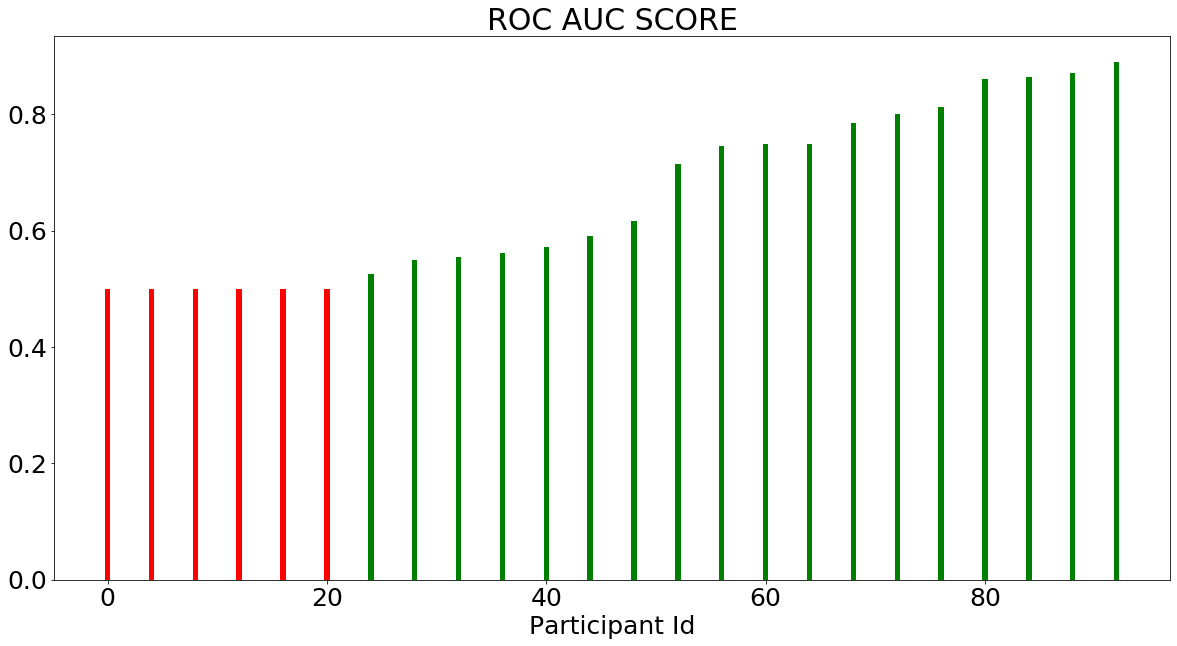

In [4]:
%matplotlib inline
plt.rcParams.update({'font.size':25})
scores = scores[scores[:,0].argsort()]
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize=(20,10),sharex=True)
ax.bar(np.arange(0,4*scores.shape[0],4)[scores[:,0]<=.5],scores[scores[:,0]<=.5,0],.5,color='r')
ax.bar(np.arange(0,4*scores.shape[0],4)[scores[:,0]>.5],scores[scores[:,0]>.5,0],.5,color='g')
ax.set_title('ROC AUC SCORE')
# ax[0,1].bar(np.arange(scores.shape[0]),scores[:,1],.5)
# ax[1,0].bar(np.arange(scores.shape[0]),scores[:,2],.5)
# ax[1,1].bar(np.arange(scores.shape[0]),scores[:,3],.5,color='r')
ax.set_xlabel('Participant Id')
# ax.set_xlabel('Participant Id')

In [5]:
np.mean(scores,axis=0)

array([0.65911813, 0.61680386, 0.900684  , 0.69715601, 0.66203174])

[[1 7]
 [0 7]]
           mean_s  std_s
indicator               
0.0             1      1
1.0             7      7
11.0            7      7


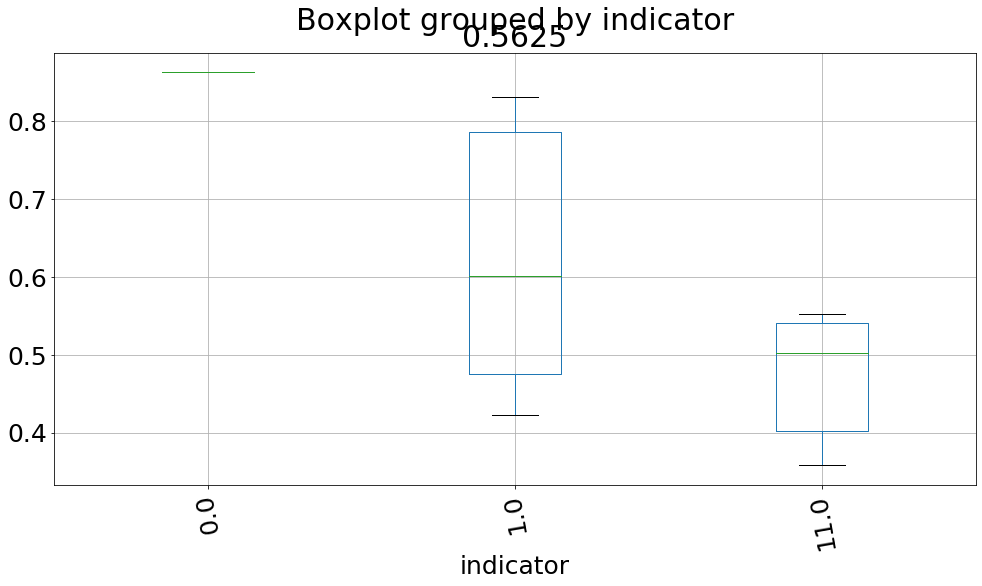

[[13  5]
 [ 0  5]]
           mean_s  std_s
indicator               
0.0            13     13
1.0             5      5
11.0            5      5


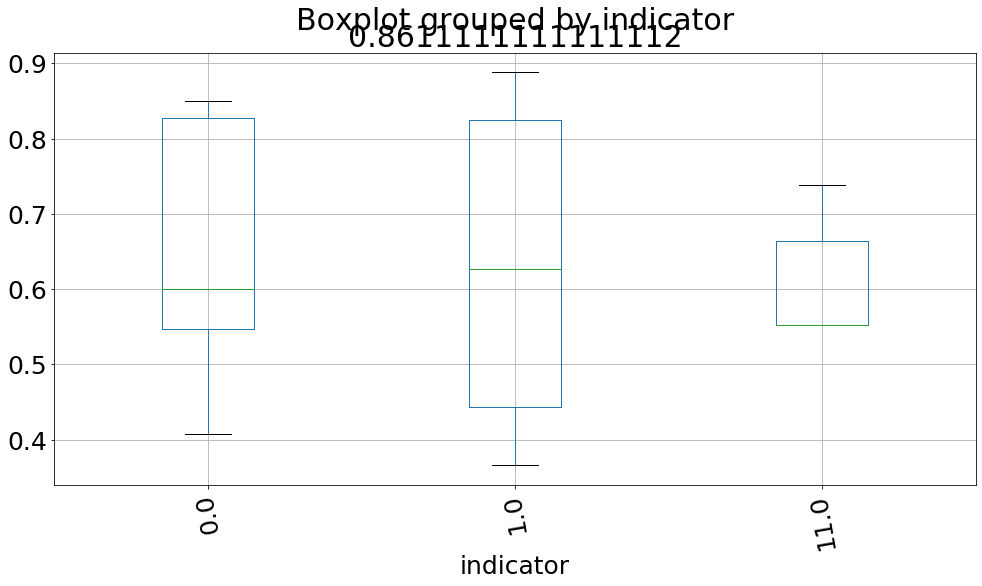

[[3 6]
 [1 9]]
           mean_s  std_s
indicator               
0.0             3      3
1.0             6      6
10.0            1      1
11.0            9      9


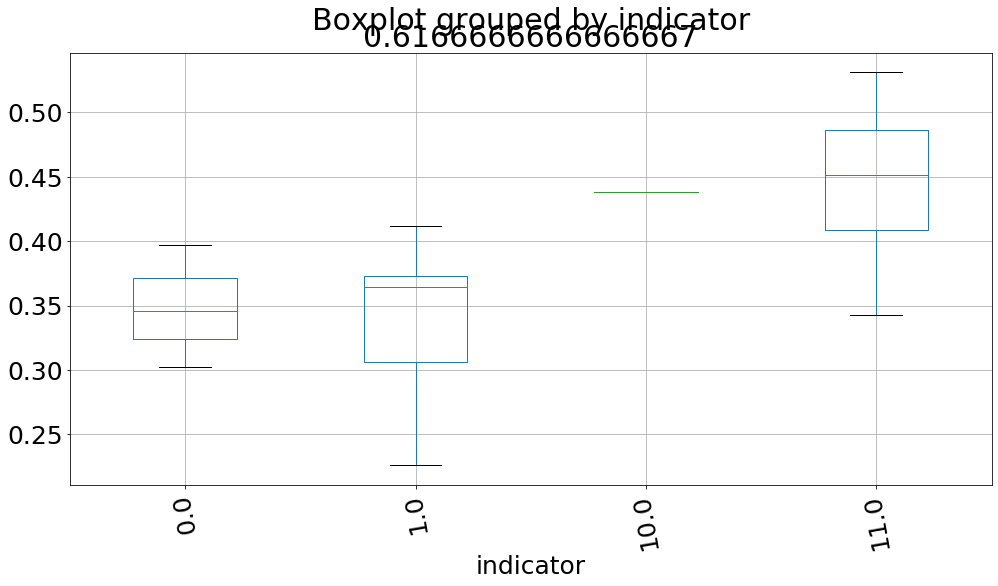

[[2 9]
 [0 3]]
           mean_s  std_s
indicator               
0.0             2      2
1.0             9      9
11.0            3      3


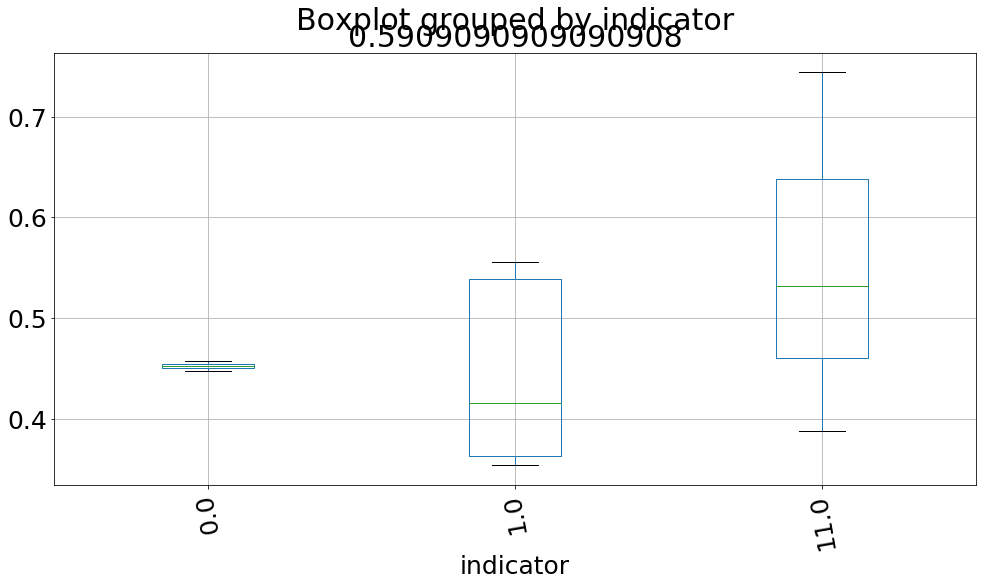

[[8 3]
 [0 3]]
           mean_s  std_s
indicator               
0.0             8      8
1.0             3      3
11.0            3      3


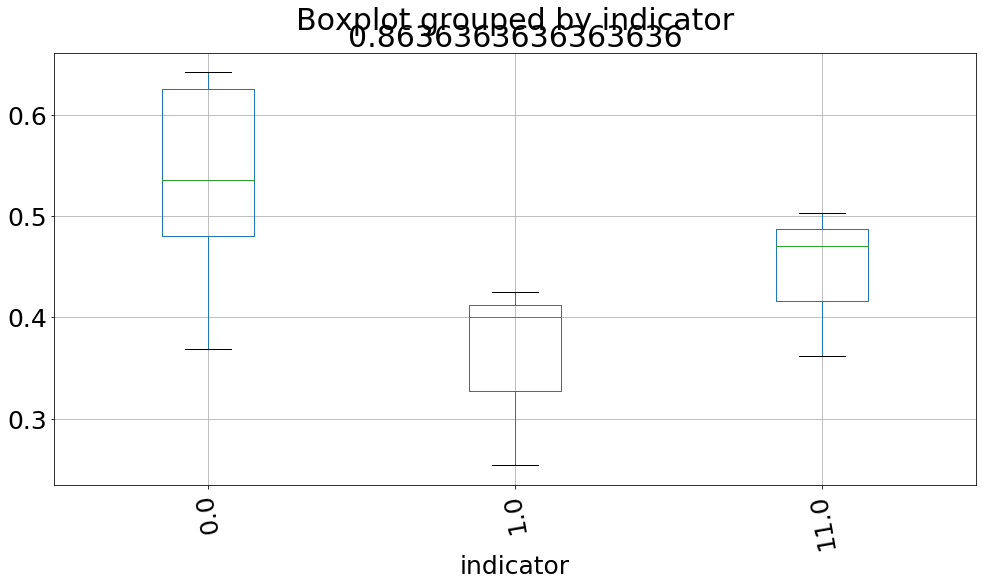

[[12  1]
 [ 1  6]]
           mean_s  std_s
indicator               
0.0            12     12
1.0             1      1
10.0            1      1
11.0            6      6


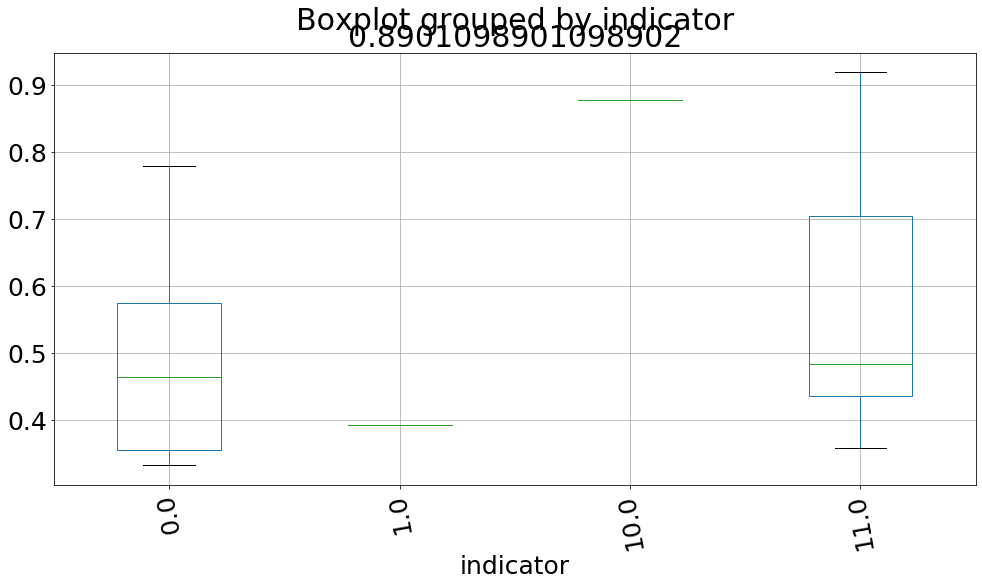

[[10  2]
 [ 2  4]]
           mean_s  std_s
indicator               
0.0            10     10
1.0             2      2
10.0            2      2
11.0            4      4


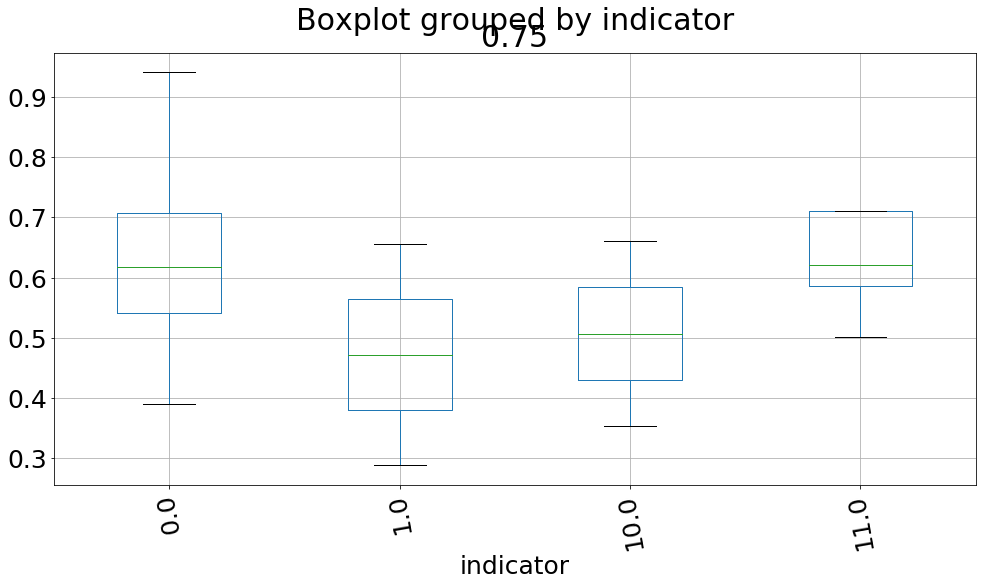

[[ 1  9]
 [ 0 11]]
           mean_s  std_s
indicator               
0.0             1      1
1.0             9      9
11.0           11     11


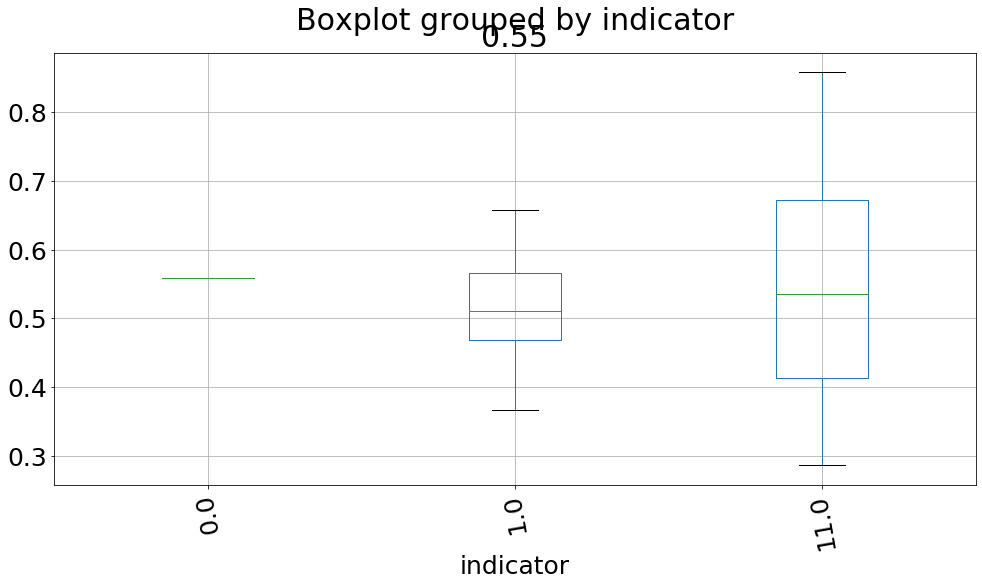

[[ 0  8]
 [ 0 12]]
           mean_s  std_s
indicator               
1.0             8      8
11.0           12     12


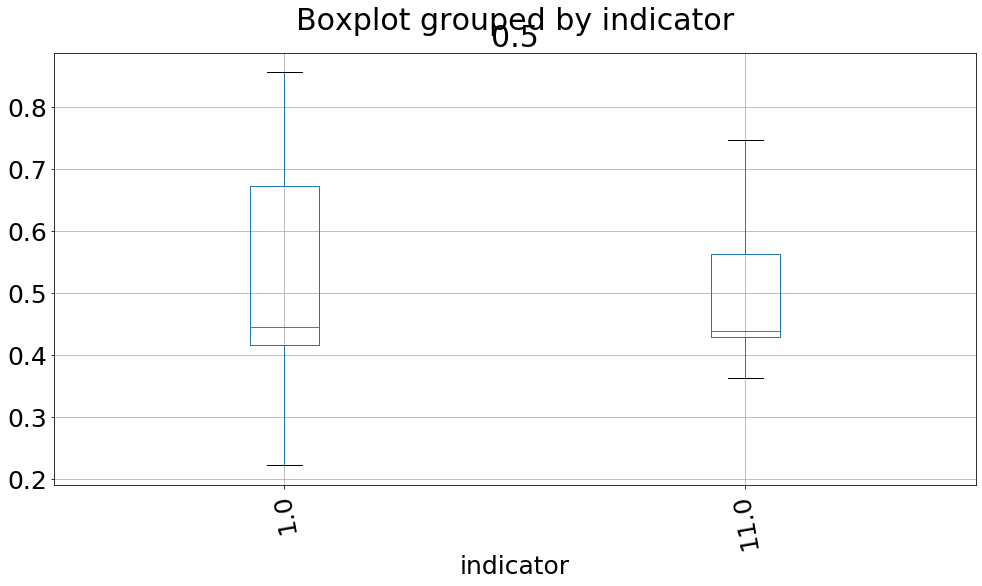

[[15  0]
 [ 2  2]]
           mean_s  std_s
indicator               
0.0            15     15
10.0            2      2
11.0            2      2


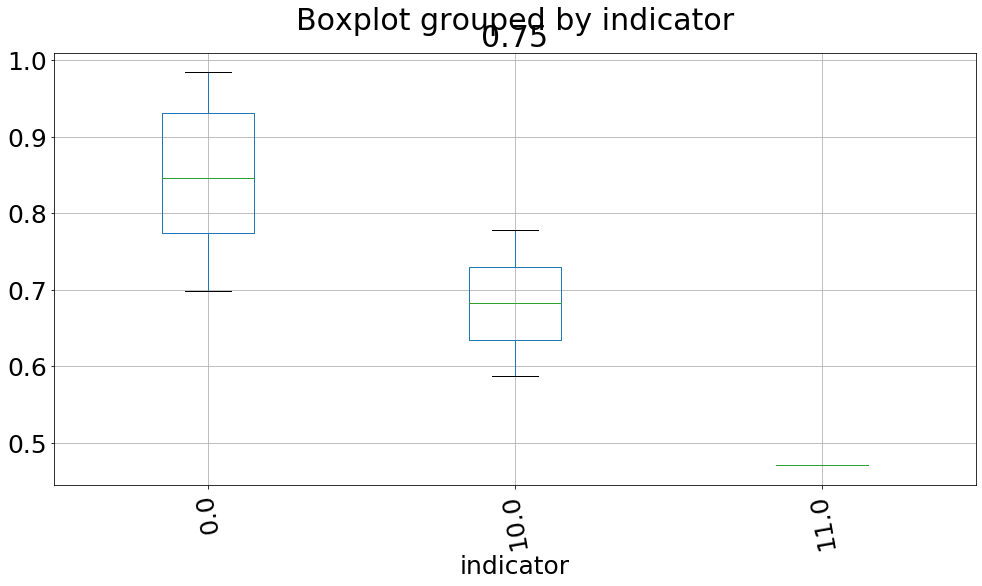

[[8 1]
 [2 5]]
           mean_s  std_s
indicator               
0.0             8      8
1.0             1      1
10.0            2      2
11.0            5      5


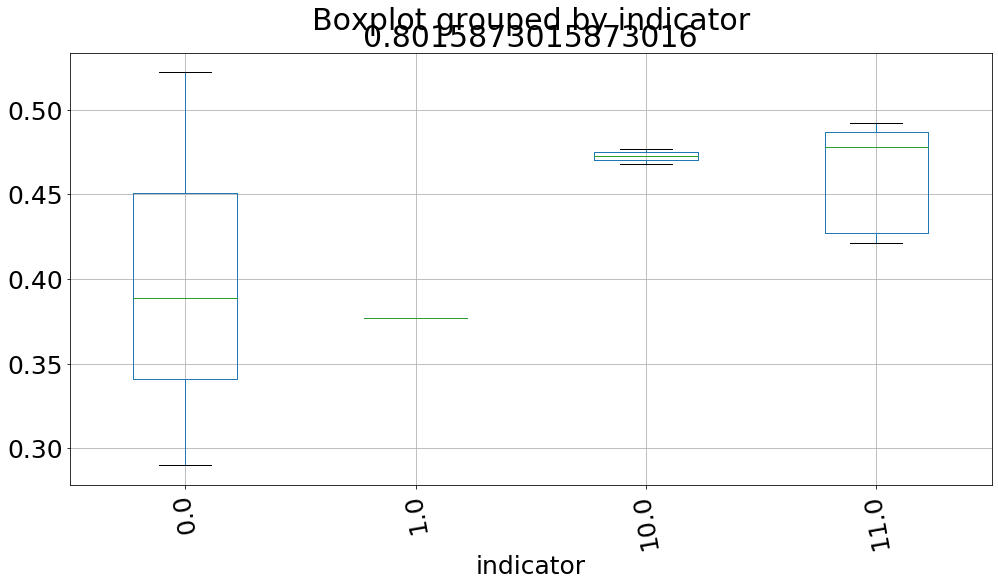

[[10  1]
 [ 1  5]]
           mean_s  std_s
indicator               
0.0            10     10
1.0             1      1
10.0            1      1
11.0            5      5


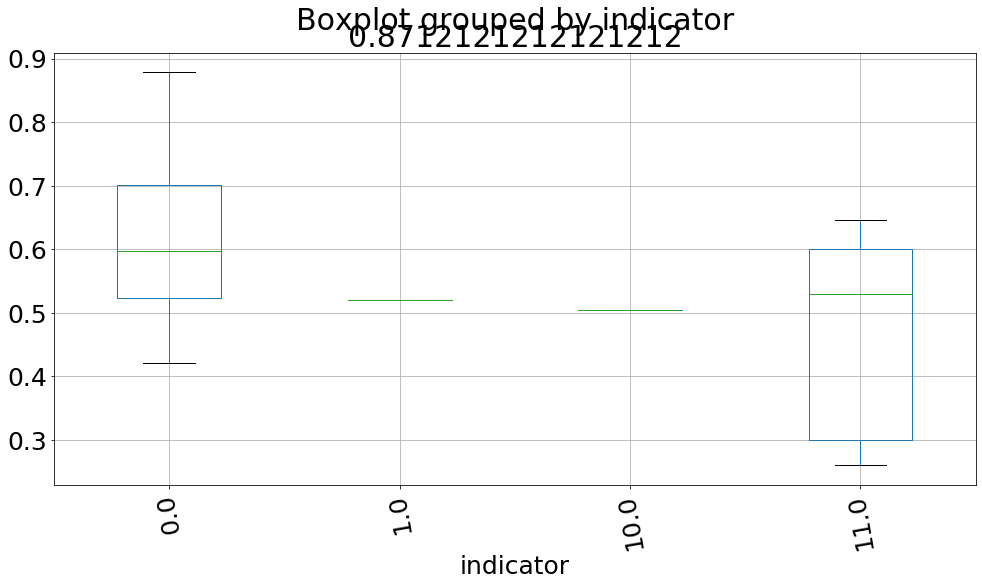

[[ 0  8]
 [ 0 14]]
           mean_s  std_s
indicator               
1.0             8      8
11.0           14     14


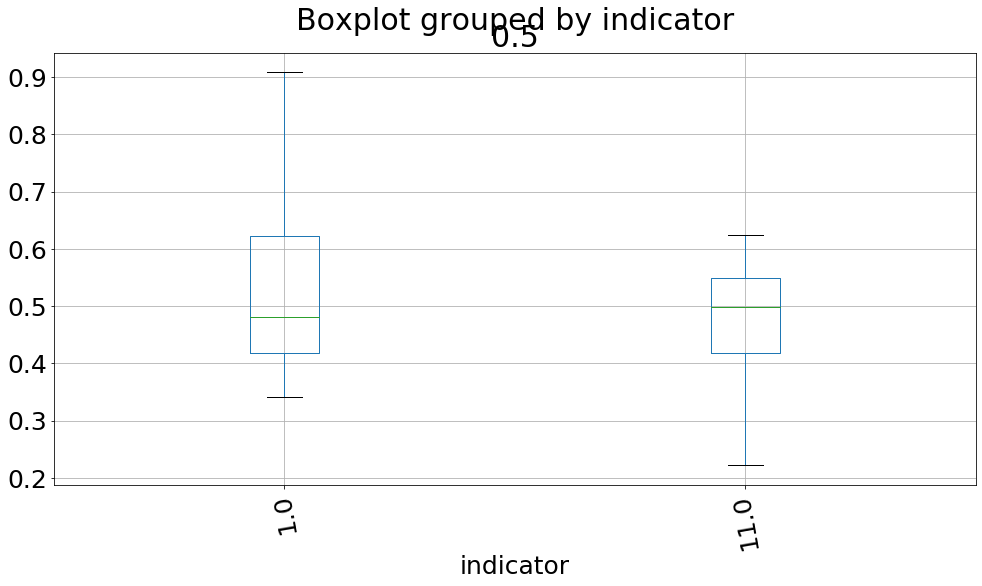

[[ 0  3]
 [ 0 14]]
           mean_s  std_s
indicator               
1.0             3      3
11.0           14     14


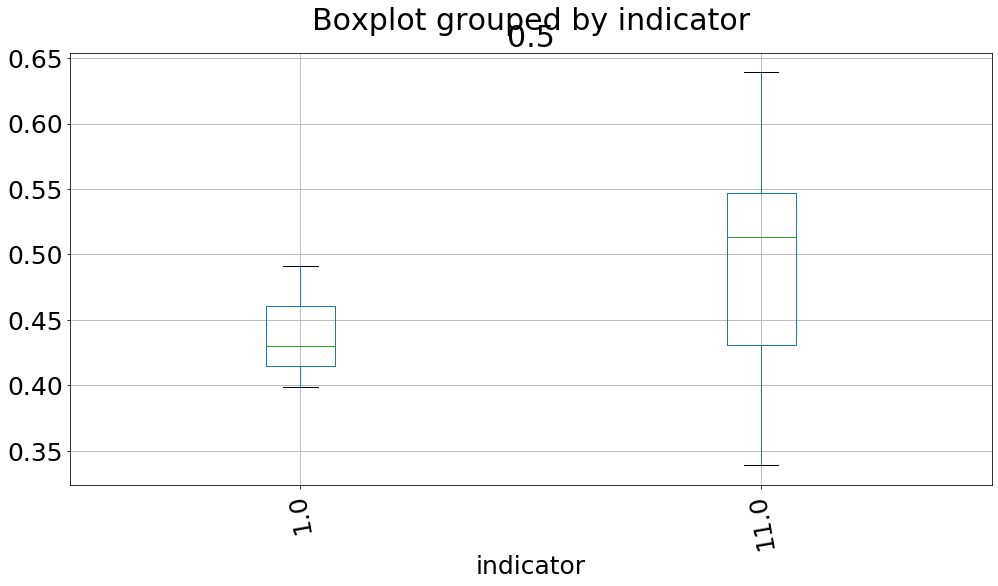

[[7 1]
 [1 3]]
           mean_s  std_s
indicator               
0.0             7      7
1.0             1      1
10.0            1      1
11.0            3      3


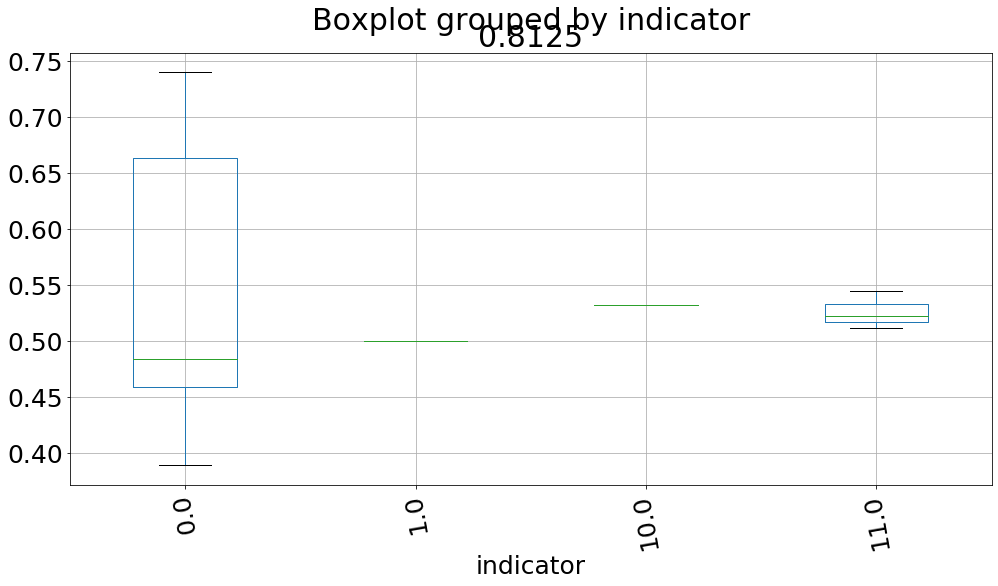

[[1 8]
 [0 3]]
           mean_s  std_s
indicator               
0.0             1      1
1.0             8      8
11.0            3      3


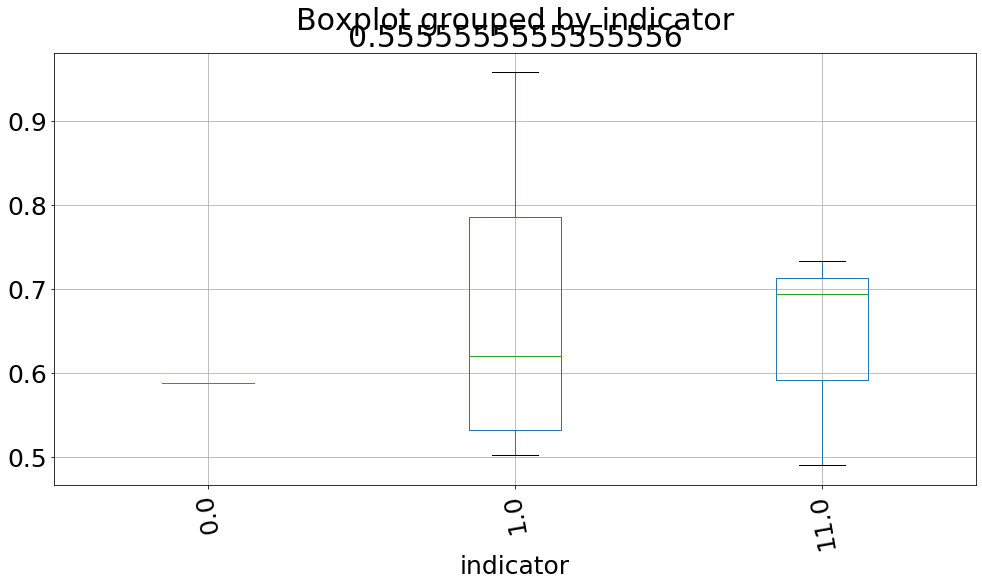

[[ 6  5]
 [ 1 18]]
           mean_s  std_s
indicator               
0.0             6      6
1.0             5      5
10.0            1      1
11.0           18     18


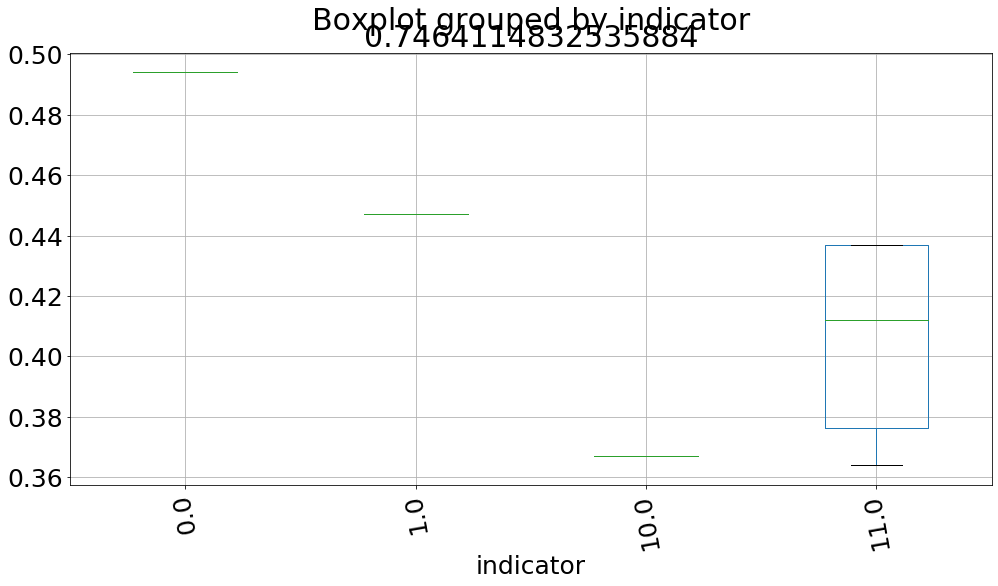

[[6 1]
 [2 5]]
           mean_s  std_s
indicator               
0.0             6      6
1.0             1      1
10.0            2      2
11.0            5      5


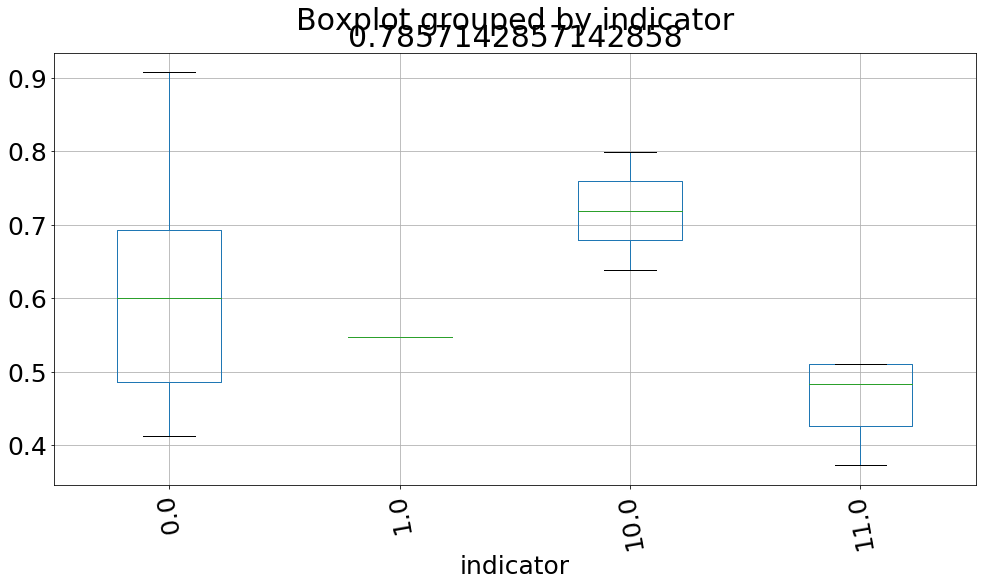

[[ 0 22]
 [ 0  9]]
           mean_s  std_s
indicator               
1.0            22     22
11.0            9      9


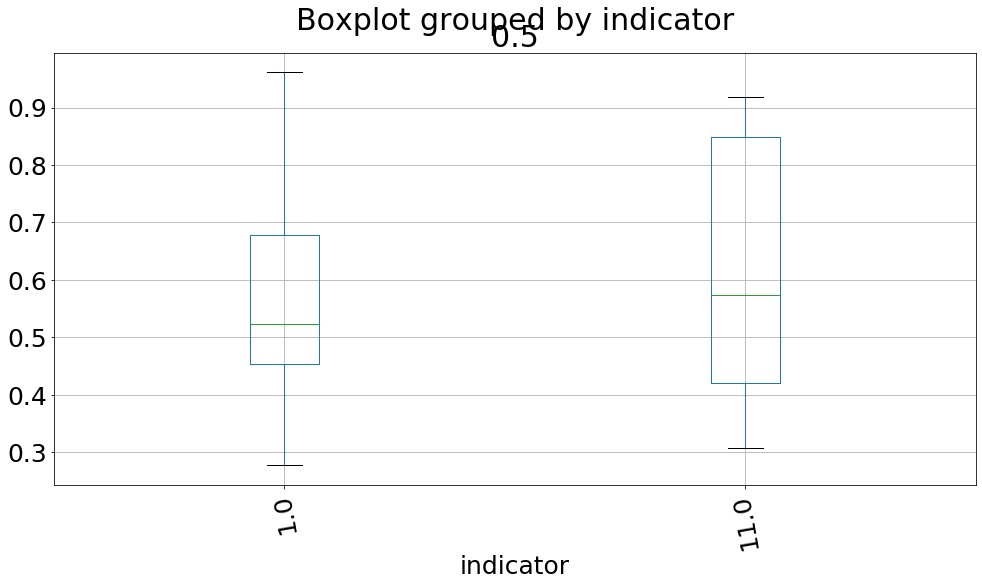

[[16  7]
 [ 4 11]]
           mean_s  std_s
indicator               
0.0            16     16
1.0             7      7
10.0            4      4
11.0           11     11


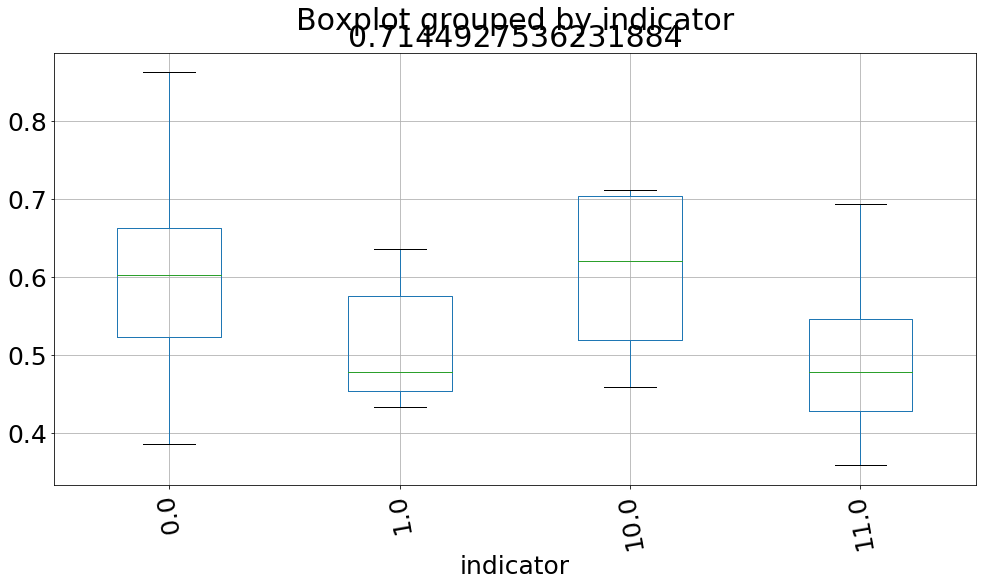

[[ 0 22]
 [ 0 18]]
           mean_s  std_s
indicator               
1.0            22     22
11.0           18     18


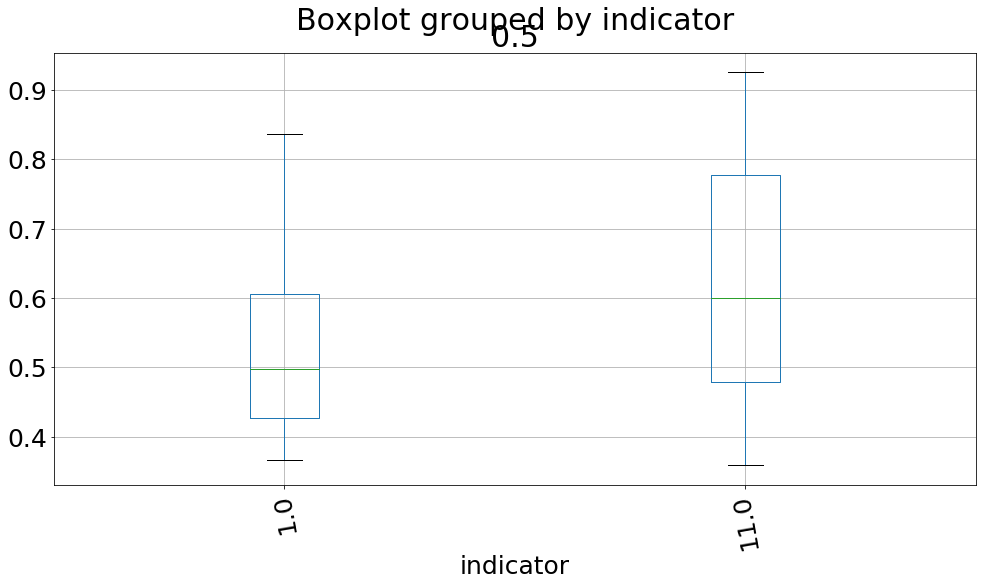

[[ 1 19]
 [ 0 21]]
           mean_s  std_s
indicator               
0.0             1      1
1.0            19     19
11.0           21     21


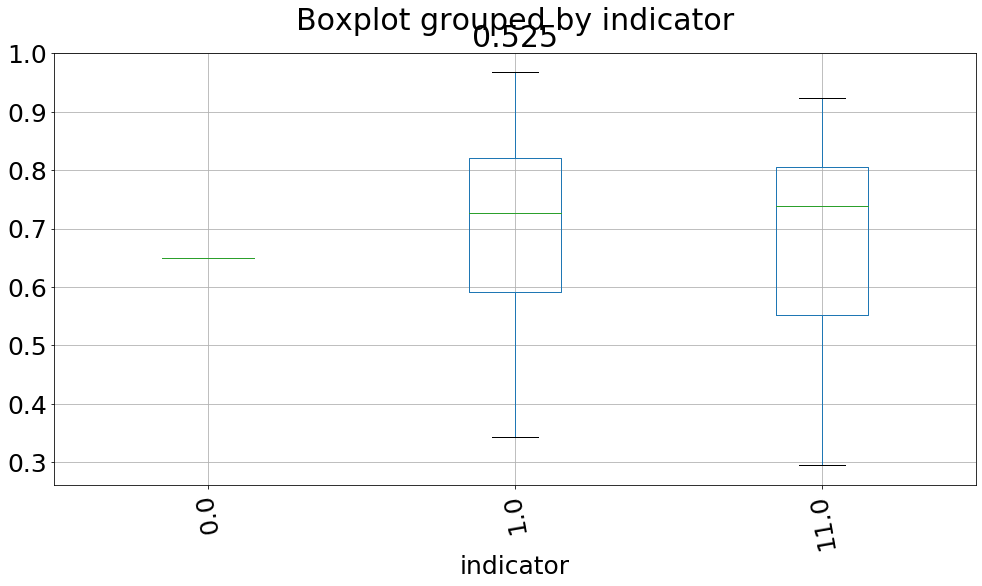

[[ 0 19]
 [ 0 20]]
           mean_s  std_s
indicator               
1.0            19     19
11.0           20     20


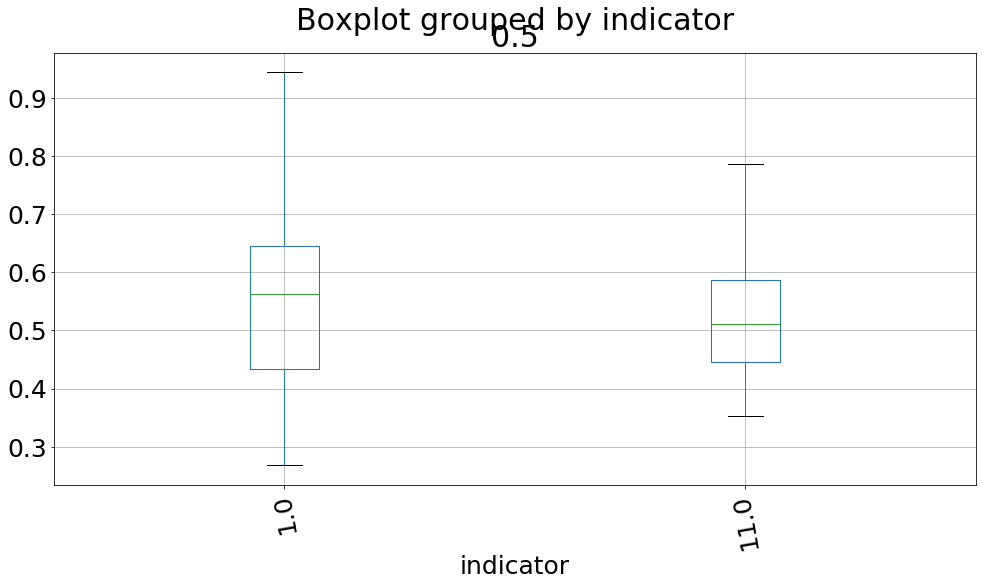

[[ 1  6]
 [ 0 10]]
           mean_s  std_s
indicator               
0.0             1      1
1.0             6      6
11.0           10     10


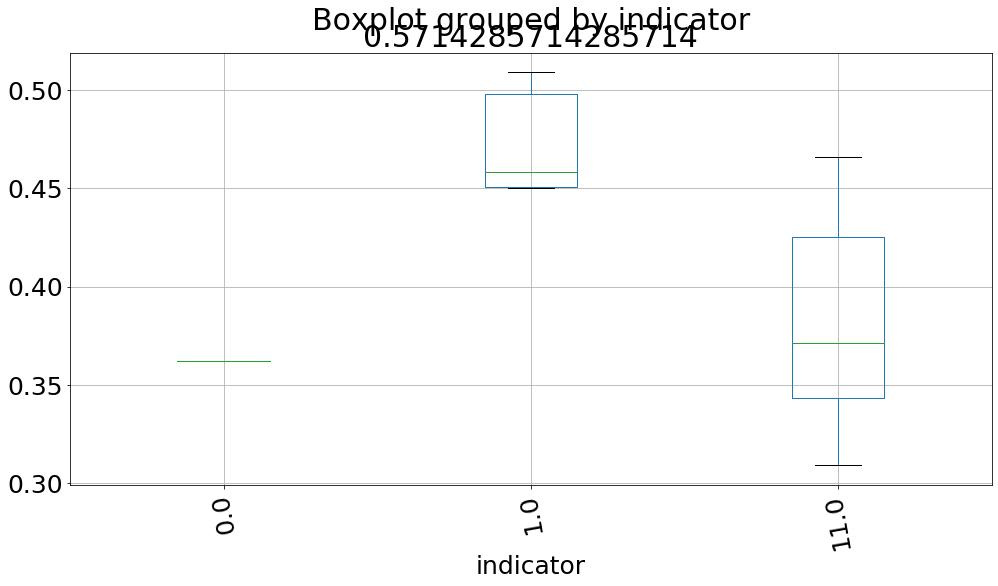

In [11]:

for y,y_pred,qual in a:
    if len(y)==0:
        continue
    temp = []
    qual_mean = np.array([np.mean(a) for a in qual])
    qual_std = np.array([np.std(a) for a in qual])
    for j in range(len(y)):
        temp.append([10*y[j]+y_pred[j],qual_mean[j],qual_std[j]])
    df = pd.DataFrame(temp,columns=['indicator','mean_s','std_s'])
    fig, ax = plt.subplots(figsize=(16,8))
    print(confusion_matrix(y,y_pred))
    plt.suptitle('')
    c = df.boxplot(column=['mean_s'], by='indicator', ax=ax,showfliers=False)
    print(df.groupby('indicator').count())
    plt.xticks(rotation=100)
    plt.title(roc_auc_score(y,y_pred))
    plt.show()

(array([1, 2, 3]), <a list of 3 Text xticklabel objects>)

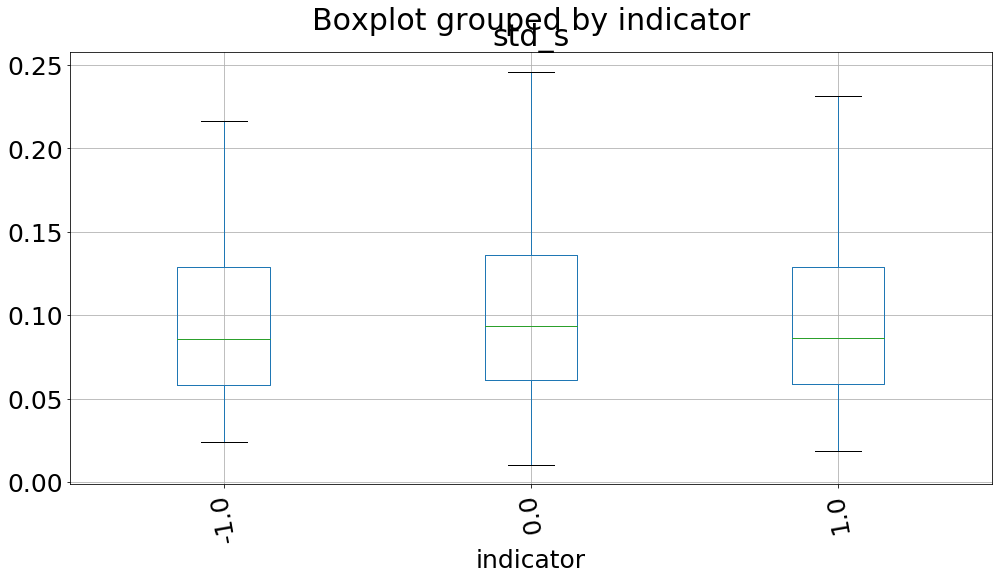